# Spectral Methods
Spectral methods are a family of techniques used in machine learning for analyzing the properties of data through the spectrum of a matrix associated with the data. These methods are based on linear algebra and eigenvalue/eigenvector computations. They are widely used in data clustering, classification, denoising, signal separation, dimension reduction, etc. This introduction will cover several widely used spectral methods and related techniques to them.

This notebook uses tree different astronomical dataset:
1. Simulated HI observations and foregrounds.(Simulated using [CRIME](https://arxiv.org/abs/1405.1751))
2. [BC03](https://arxiv.org/abs/astro-ph/0309134) Spectrum dataset
3. [Galaxy10 DECals Dataset](https://astronn.readthedocs.io/en/latest/galaxy10.html)

This notebook should be directly runable in Metis. All datasets are located at /work/dante/scripts/SpectralMethodsIntro/data. You can copy the datasets from this directory or directly use the dataset locations specified in this notebook.

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

## PCA
**PCA is a widely used spectral method for dimensionality reduction in machine learning. It identifies and represents essential patterns and structures within high-dimensional data by transforming sets of correlated variables into uncorrelated principal components that capture significant data variation.**

Here I will demonstrate how to utilize Principal Component Analysis (PCA) to remove foreground in HI observations.

In [3]:

'''
load the data set, here the sky is the foreground, HI is the mock HI signal.
'''

sky=np.load(f'data/SKY.npy')
sky=np.transpose(sky,(1,2,0))# transpose to size[N_pix_x,N_pix_y,freq]

HI=np.load(f'data/HI.npy')
HI=np.transpose(HI,(1,2,0))# transpose to size[N_pix_x,N_pix_y,freq]

Text(0.5, 1.0, '21cm')

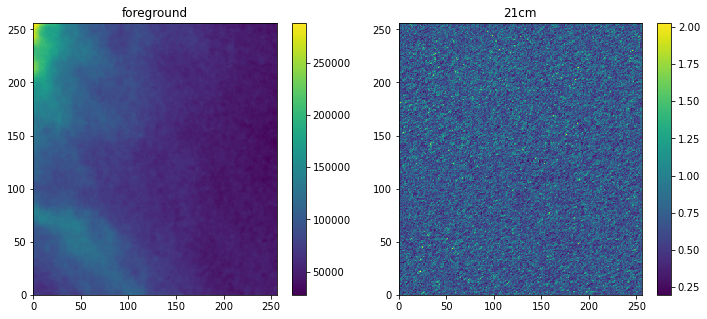

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121)

plt.pcolor(sky[:,:,0])
plt.colorbar()
plt.title("foreground")

plt.subplot(122)
plt.pcolor(HI[:,:,0])
plt.colorbar()
plt.title("21cm")

In [20]:
#generate mock observation, here we only consider one simple observational effect:thermal noise
d=(HI+sky+np.random.normal(0,0.05,(256,256,150)))

Text(0.5, 1.0, 'mock observation')

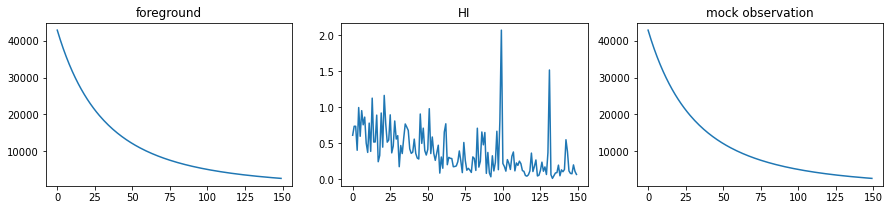

In [19]:
plt.figure(figsize=(15,3))
idxx=np.random.randint(256)
idxy=np.random.randint(256)
plt.subplot(131)
plt.plot(sky[idxx,idxy,:])
plt.title("foreground")

plt.subplot(132)
plt.plot(HI[idxx,idxy,:])
plt.title("HI")

plt.subplot(133)
plt.plot(d[idxx,idxy,:])
plt.title("mock observation")



In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
fg_est=pca.fit_transform(d.reshape(-1,150))
fg_est=pca.inverse_transform(fg_est)

In [23]:
fg_est=fg_est.reshape(256,256,150)
HI_est=d-(fg_est)

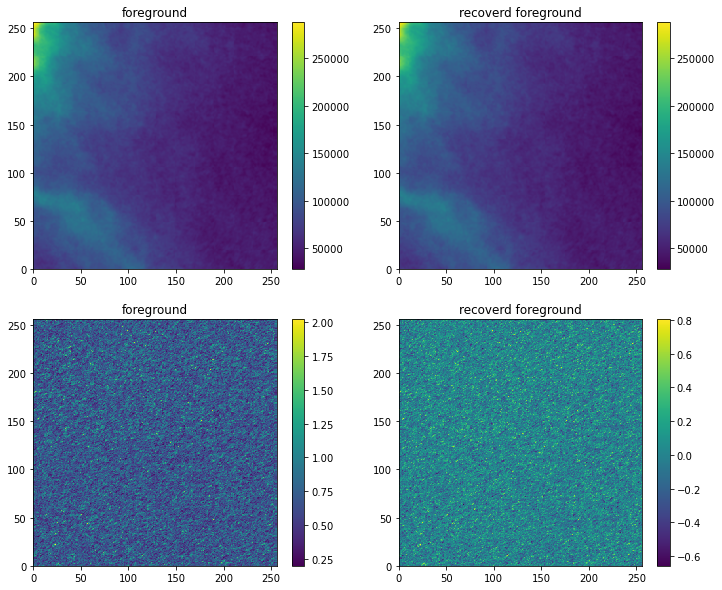

In [24]:
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.pcolor(sky[:,:,0])
plt.title("foreground")
plt.colorbar()

plt.subplot(222)
plt.pcolor(fg_est[:,:,0])
plt.title("recoverd foreground")
plt.colorbar()

plt.subplot(223)
plt.pcolor(HI[:,:,0])
plt.title("foreground")
plt.colorbar()

plt.subplot(224)
plt.pcolor(HI_est[:,:,0])
plt.title("recoverd foreground")
plt.colorbar()

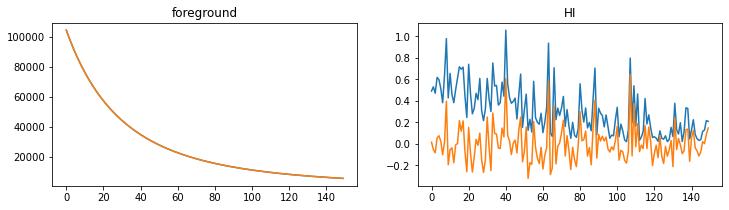

In [25]:
plt.figure(figsize=(12,3))
idxx=np.random.randint(256)
idxy=np.random.randint(256)
plt.subplot(121)
plt.plot(sky[idxx,idxy,:])
plt.title("foreground")


# plt.subplot(222)
plt.plot(fg_est[idxx,idxy,:])
# plt.title("recoverd foreground")

plt.subplot(122)
plt.plot(HI[idxx,idxy,:])
plt.title("HI")
plt.plot(HI_est[idxx,idxy,:])



## ICA
Principal Component Analysis (PCA) is a method that enables the decorrelation of different dimensions of data samples by projecting them onto a new space where the covariances of dimensions are zero. This technique is useful in Blind Source Separation where the aim is to decompose input mixture signals into uncorrelated components. However, it is important to note that uncorrelatedness is a weaker form of independence. To address this limitation, **we can assume that the underlying source signals are independently distributed. This assumption leads to the Independent Component Analysis (ICA) method.**

I will demonstrate how Independent Component Analysis (ICA) can be applied to a "common" scenario in observational studies, where the observed spectrum is mixed with an alien signal that uses sinusoidal waves to communicate. 

In [26]:
import joblib
BC03 = joblib.load('/work/dante/scripts/SpectralMethodsIntro/data/BC03.pkl')
flux=BC03['flux']# the spectrums
info=BC03['info']# the properties of spetrums
x=BC03['wave']#wavelengths

In [27]:
#generate a sinusoidal wave
sin_comp=np.sin(x) 

#randomize the sin signal and add ot to the spectrums
mixed_signal=(sin_comp*(np.random.random(size=(flux.shape[0],1))+0.5))+flux 

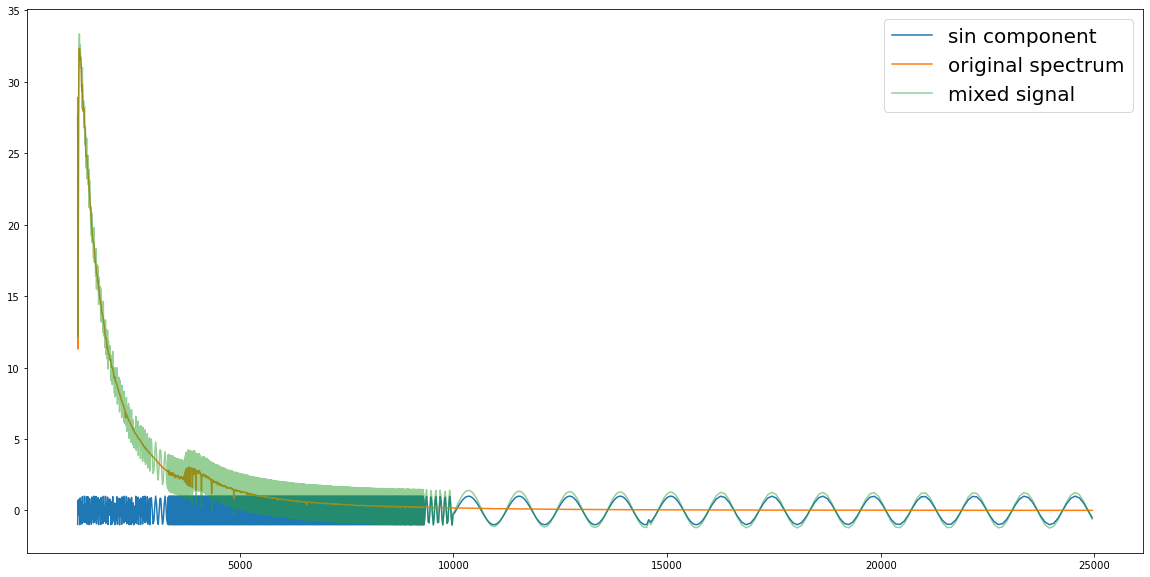

In [45]:
plt.figure(figsize=(20,10))
plt.plot(x,sin_comp,label='sin component')
plt.plot(x,flux[100],label='original spectrum')
plt.plot(x,mixed_signal[100],label='mixed signal',alpha=0.5)
plt.legend(fontsize=20)

In [126]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=5,
        random_state=0,
        whiten="unit-variance",
             max_iter=1000)
sep_src = ica.fit_transform(mixed_signal.T)

(-5.0, 5.0)

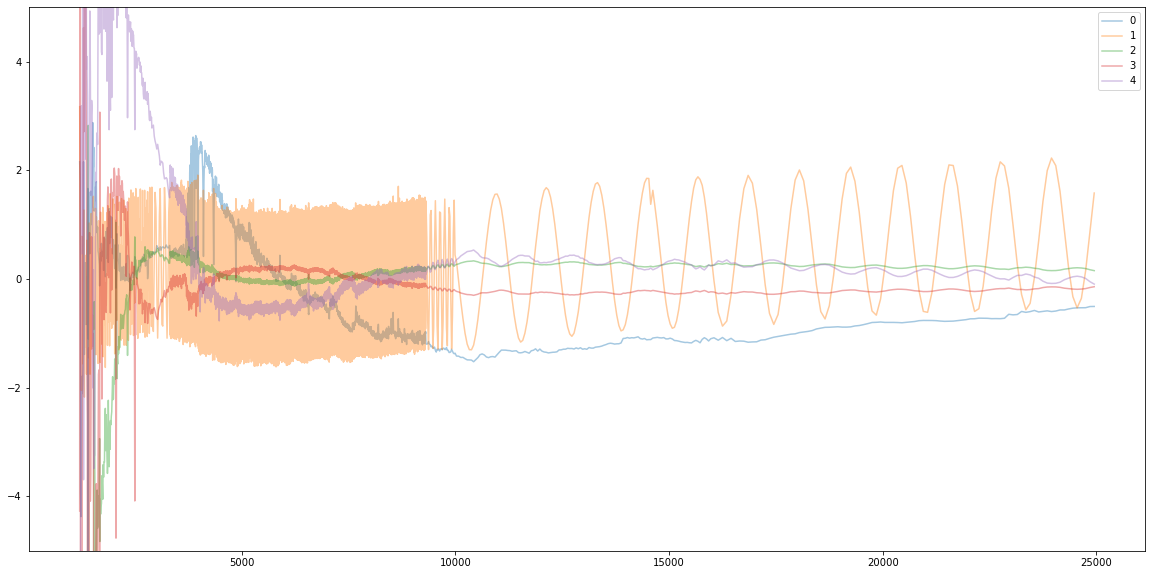

In [127]:
plt.figure(figsize=(20,10))
for i in range(sep_src.shape[1]):
    plt.plot(x,sep_src[:,i],label=f'{i}',alpha=0.4)
plt.legend()
plt.ylim(-5,5)

In [128]:
sep_src[:,1]=0
rec=ica.inverse_transform(sep_src).T

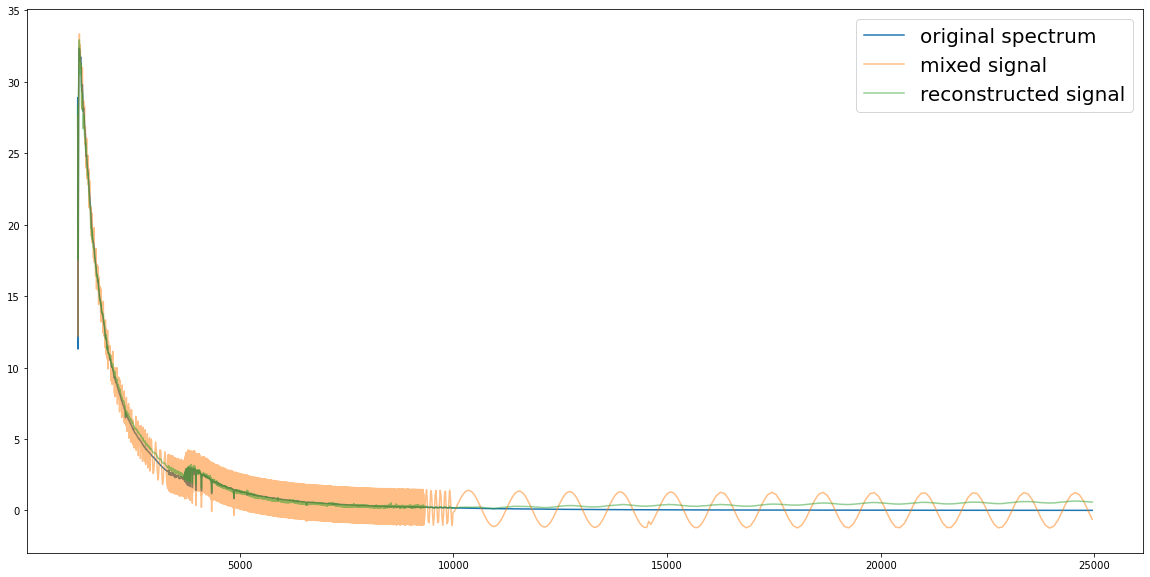

In [129]:
plt.figure(figsize=(20,10))
plt.plot(x,flux[100],label='original spectrum')
plt.plot(x,mixed_signal[100],label='mixed signal',alpha=0.5)
plt.plot(x,rec[100],label='reconstructed signal',alpha=0.5)
plt.legend(fontsize=20)

## LDA
Both PCA and ICA are unsupervised techniques for discovering a projection space that meets specific goals, such as decorrelation of data dimensions or the recovery of independent sources. However, in certain cases, such as classification tasks, we work with labeled data and aim to project the data samples into spaces that can better differentiate different classes of data points. In such cases, Fisher's Linear Discriminant Analysis (FLDA or simply LDA) can be used. **LDA identifies a projection that maximizes the separation between different labeled classes while also minimizing the variance within the classes.** LDA provides a method for dimensionality reduction while retaining the class-discriminatory information, making it useful for supervised learning tasks.

We will continue to use the spectrum dataset, but this time we will consider one of its physical properties, redshift, as labels.

In [130]:
##first let's try pca again
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
flux_2d=pca.fit_transform(flux)

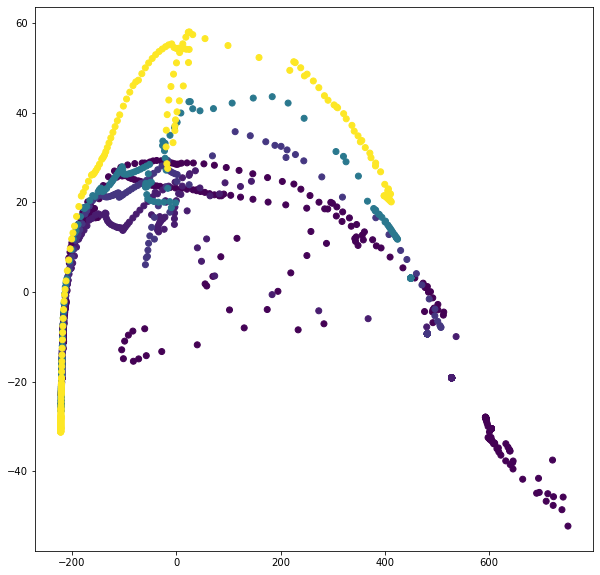

In [132]:
plt.figure(figsize=(10,10))
plt.scatter(flux_2d[:,0],flux_2d[:,1],c=info['z'])

PCA projections cannot fully capture the underlying structure of the data because they do not incorporate the label information.

In [142]:
# first let define several functions to generate dataset with labels.
def property_to_label(ps):
    '''
    transform physical properties to labels [0,1,2,...]
    '''
    p_uni=np.unique(ps)
    labels=np.zeros_like(ps,dtype=np.int64)
    for i,p in enumerate(p_uni):
        labels[ps==p]=i
    return labels

def get_dataset(flux,ps,label_idx):
    '''
    get a subdataset containing data samples that have labels listed in label_idx
    '''
    labels=property_to_label(ps)
    data_idx=np.zeros(len(labels))
    for l in label_idx:
        data_idx=np.logical_or(labels==l,data_idx)
    
    dataset=flux[data_idx]
    label=labels[data_idx]
    
    return dataset,label
        
        

In [143]:
X,y=get_dataset(flux,info['z'],[0,1,2])#we only consider the first three redshifts

In [145]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
flux_2d_lda = lda.fit_transform(X, y)

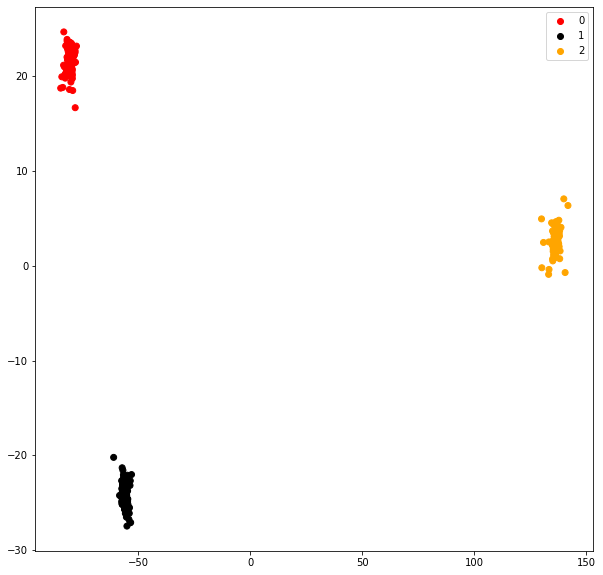

In [146]:
plt.figure(figsize=(10,10))
from matplotlib.colors import ListedColormap
classes=[0,1,2,3,4,5,6]
colors = ListedColormap(['r','b','g','black','yellow','orange'])
scatter=plt.scatter(flux_2d_lda[:,0],flux_2d_lda[:,1],c=y,cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
# plt.legend()

By utilizing Linear Discriminant Analysis (LDA), we are able to clearly distinguish and separate different data samples based on their corresponding labels.

## Metric Learning
**Another supervised method involving the projection of data samples is metric learning. (There are also unsupervised metric learning methods, here I only focus on the supervised ones) The goal of this approach is to learn a distance metric from the training data that places data samples with the same class label closer together. Usually, Euclidean distance is used to measure the similarity between different data samples. However, this metric may not provide an accurate evaluation of similarity when the data structure is complicated.**

To demonsrate how metric learning or how the LMNN algorithm works, I will use a dataset consisting of galaxy images with labels that describe their morphologies. However, this may not be the most optimal example for applying LMNN to astronomy for two reasons: Firstly, the LMNN algorithm works slowly with high-dimensional data. Secondly, we will not be using a validation set in this demonstration. In real-world applications, using a validation set is crucial for accurate model performance evaluation.

In [147]:
with h5py.File('data/Galaxy10_DECals_Lowres.h5', 'r') as F:
    '''   
    the original dataset is in data/Galaxy10_DECals.h5. 
    I downsampled the original images into 64*64 and store them into Galaxy10_DECals_Lowres.h5 
    '''
    X_all = np.array(F['images'])
    y_all = np.array(F['labels'])

In [157]:
#the correspondence of labels and morphology description
label_to_morphology={0:'Disturbed Galaxies',
                     1:'Merging Galaxies',
                     2:'Round Smooth Galaxies',
                     3:'In-between Round Smooth Galaxies',
                     4:'Cigar Shaped Smooth Galaxies',
                     5:'Barred Spiral Galaxies',
                     6:'Unbarred Tight Spiral Galaxies',
                     7:'Unbarred Loose Spiral Galaxies',
                     8:'Edge-on Galaxies without Bulge',
                     9:'Edge-on Galaxies with Bulgem',}

In [153]:
'''
a simple function to randomly select samples from all the data
'''
def get_sub_dataset(X,y,size):
    idx=np.random.choice(np.arange(len(y)),size=size)
    
    return X[idx],y[idx]

In [154]:
X,y=get_sub_dataset(X_all,y_all,1000)

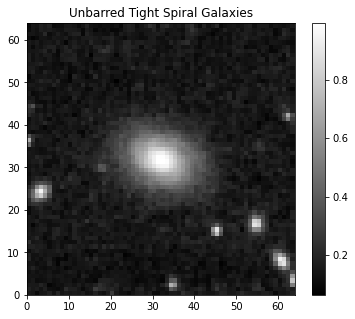

In [159]:
plt.figure(figsize=(6,5))
plt.pcolor(X[0],cmap='gray')
plt.colorbar()
plt.title(label_to_morphology[y[0]]);

In [160]:

def find_N_neighbors(dataset,target_idx,N_neighbors):
    '''
    A function to locate the N nearest neighbors of a given sample
    '''
    if len(dataset.shape)>2:
        datas=dataset.reshape(dataset.shape[0],-1)
    else:
        datas=dataset
    
    target=datas[target_idx]
    dis=np.sqrt(np.sum((datas-target)**2,axis=1))
    
    neighbor_idx=np.argsort(dis)[1:N_neighbors+1]
    
    return neighbor_idx

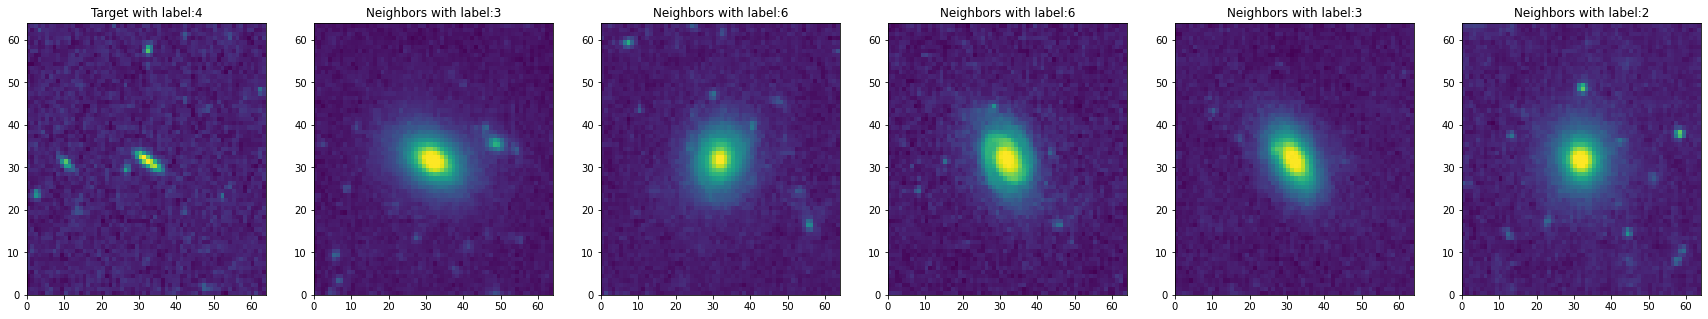

In [171]:
target_idx=5
N_neighbors=5

nidx=find_N_neighbors(X,target_idx=0,N_neighbors=5)

plt.figure(figsize=((N_neighbors+1)*5,5))
plt.subplot(1,N_neighbors+1,1)
plt.pcolor(X[target_idx])
plt.title(f'Target with label:{y[target_idx]}')
for i in range(N_neighbors):
    plt.subplot(1,N_neighbors+1,i+2)
    plt.pcolor(X[nidx[i]])
    plt.title(f'Neighbors with label:{y[nidx[i]]}')

We can observe that it is not possible to accurately represent the morphological similarity between galaxies using the Euclidean distance metric. Next let's try LMNN to see if we can achieve better results.

In [164]:
from metric_learn import LMNN

In [169]:
X_=X.reshape(X.shape[0],-1)
lmnn = LMNN(k=3, learn_rate=1e-3,verbose=False,max_iter=100)
lmnn.fit(X_, y)
X_lmnn = lmnn.transform(X_)

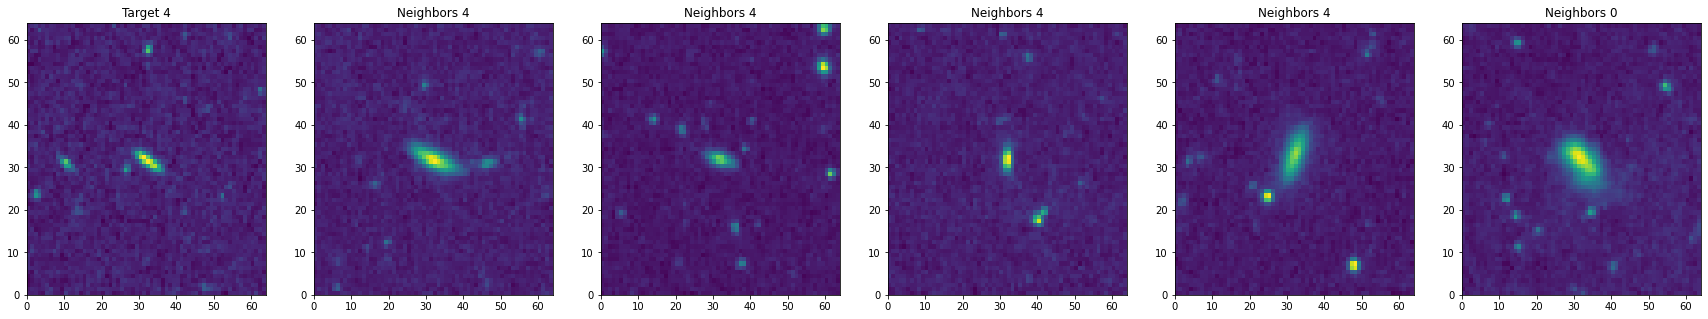

In [170]:
nidx=find_N_neighbors(X_lmnn,target_idx,N_neighbors)
plt.figure(figsize=((N_neighbors+1)*5,5))
plt.subplot(1,N_neighbors+1,1)
plt.pcolor(X[target_idx])
plt.title(f'Target {y[target_idx]}')
for i in range(N_neighbors):
    plt.subplot(1,N_neighbors+1,i+2)
    plt.pcolor(X[nidx[i]])
    plt.title(f'Neighbors {y[nidx[i]]}')

As shown, the nearest neighbors of the given sample have similar morphologies, indicating that we have potentially found a metric for evaluating morphological similarities.